In [2]:
from graph_spectrogram import *
from local_search import *
from sum_bandwidth_2 import *
from reduce_bandwith_with_spectrogram import *

You have not installed gurobi : you will not be able to use it
pygame 2.0.0 (SDL 2.0.12, python 3.7.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
N = 90
graph_sbm = create_sbm_graph(N)
weights = get_adjacency_matrix(graph_sbm)


In [4]:
#permutation_allister = mc_allister(weights)
#CM_permutation = get_cuthill_mckee(weights)
#SS_permutation = spectral_sequencing(weights)
#improved_solution = median_improvement(weights, best_mc_allister_permutation)
#further_improved_solution = median_improvement_while_benefitial(weights, further_improved_solution, stop_criterion='repetition')

In [17]:
colors = ['r', 'g', 'y', 'k', 'c', 'm', 'b']

In [20]:
def test_bandwith_reduction_algorithms(algorithms, nb_repartitions=1,nb_of_nodes=90, nb_of_tests=40, plot_densities=False):
    bddwths_algorithms = [[] for _ in range(len(algorithms))]
    similarities_algorithms =  [[] for _ in range(len(algorithms))]
    similarities_greedy_permutation = []
    for i in range(nb_of_tests):
        print(f"Iteration {i+1} out of {nb_of_tests}")
        graph = create_sbm_graph(nb_of_nodes) #generate a stochastic block model graph with 3 groups
        weights = get_adjacency_matrix(graph)
        spectrogram = spectrogram_with_several_repartitions(graph, nb_repartitions)
        random_perm = np.random.permutation(nb_of_nodes)
        similarity_greedy_perm = greedy_permutation(spectrogram)
        similarities_greedy_permutation.append(similarity_measure(spectrogram, similarity_greedy_perm, norm=1))
        for ind in range(len(algorithms)):
            perm_alg = algorithms[ind](weights)
            bdwth = bandwidth_sum(perm_alg, weights)
            bddwths_algorithms[ind].append(bdwth)
            similarity = similarity_measure(spectrogram, perm_alg, norm=1)
            similarities_algorithms[ind].append(similarity)
    #print(bddwths_algorithms)
    mi = min([min(x) for x in bddwths_algorithms])-1000
    ma = max([max(x) for x in bddwths_algorithms])+1000
    X = np.linspace(mi, ma, 1000)
    for ind in range(len(algorithms)):
        kde = KDE(X, bddwths_algorithms[ind])
        plt.plot(X, kde, label=algorithms[ind].__name__, color=colors[ind])
    plt.legend()
    plt.xlabel('bandwith')
    plt.ylabel('pdf')
    plt.title('results of differet heuristic algorithms which minimize the bandwith sum')
    plt.show()
    X = np.linspace(85, 90, 1000) 
    plt.plot(X, KDE(X, similarities_greedy_permutation), label='greedy similarity indicator')
    for ind in range(len(algorithms)):
        kde = KDE(X, similarities_algorithms[ind])
        plt.plot(X, kde, label=algorithms[ind].__name__, color=colors[ind])
    plt.legend()
    plt.xlabel('similarity indicator')
    plt.ylabel('pdf')
    plt.title('similarity indicator repartition for different bandwith reduction heuristics')
    plt.show()
    
    
    
    
    
    

Iteration 1 out of 40
Iteration 2 out of 40
Iteration 3 out of 40
Iteration 4 out of 40
Iteration 5 out of 40
Iteration 6 out of 40
Iteration 7 out of 40
Iteration 8 out of 40
Iteration 9 out of 40
Iteration 10 out of 40
Iteration 11 out of 40
Iteration 12 out of 40
Iteration 13 out of 40
Iteration 14 out of 40
Iteration 15 out of 40
Iteration 16 out of 40
Iteration 17 out of 40
Iteration 18 out of 40
Iteration 19 out of 40
Iteration 20 out of 40
Iteration 21 out of 40
Iteration 22 out of 40
Iteration 23 out of 40
Iteration 24 out of 40
Iteration 25 out of 40
Iteration 26 out of 40
Iteration 27 out of 40
Iteration 28 out of 40
Iteration 29 out of 40
Iteration 30 out of 40
Iteration 31 out of 40
Iteration 32 out of 40
Iteration 33 out of 40
Iteration 34 out of 40
Iteration 35 out of 40
Iteration 36 out of 40
Iteration 37 out of 40
Iteration 38 out of 40
Iteration 39 out of 40
Iteration 40 out of 40


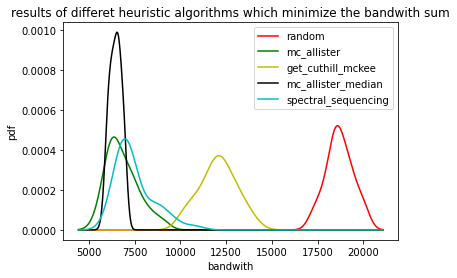

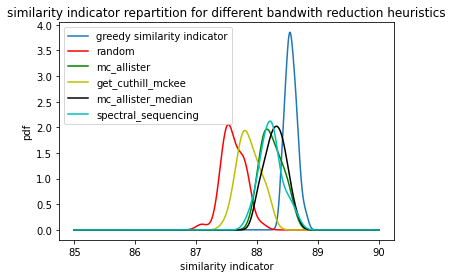

In [21]:
def random(weights):
    return np.random.permutation(len(weights))

def mc_allister_median(weights):
    perm = mc_allister(weights)
    median_imp = median_improvement(weights, perm)
    return median_imp

algorithms = [random, mc_allister, get_cuthill_mckee,  mc_allister_median, spectral_sequencing]
test_bandwith_reduction_algorithms(algorithms)
      

In [32]:
def swap_neighbour_iterator(permutation, graph, nghbs, swap_only_connected_vertices=False):
    """iterator on neighboors of permutation
    Neighboorhood is defined as all the permutation that we can get by switching 2 vertices connected by
    an edge"""
    n = graph.N
    for i in range(n):
        for j in range(i+1, n):
            if graph.W[i,j] != 0 or not swap_only_connected_vertices:
                neighbour = cp.copy(permutation)
                neighbour[i], neighbour[j] = neighbour[j], neighbour[i]
                bandwith_variation = compute_bandwith_variation(neighbour, permutation, i, j, nghbs)
                yield neighbour, bandwith_variation


def compute_bandwith_variation(res_permutation, init_permutation, i, j, nghbs):


    #vertices_connected_to_i = get_neighbors(graph, i)
    #vertices_connected_to_j = get_neighbors(graph, j)
    vertices_connected_to_i = nghbs[i]
    vertices_connected_to_j = nghbs[j]
    bandwith_variation = sum([abs(res_permutation[k] - res_permutation[i]) for k in vertices_connected_to_i]) \
                         + sum([abs(res_permutation[k] - res_permutation[j]) for k in vertices_connected_to_j]) \
                         - sum([abs(init_permutation[k] - init_permutation[i]) for k in vertices_connected_to_i]) \
                         - sum([abs(init_permutation[k] - init_permutation[j]) for k in vertices_connected_to_j])
    return bandwith_variation


def local_search(initial_solution, graph, spectrogramm=None, neighbour_iterator=swap_neighbour_iterator,
                 nb_max_iter=1000):

    initial_solution = list(initial_solution)
    nghbs = [get_neighbors(graph, i) for i in range(graph.N)]
    weights = get_adjacency_matrix(graph)
    bandwith = bandwidth_sum(initial_solution, weights)
    best_value = bandwith
    best_sol = cp.copy(initial_solution)
    stop = False
    cpt = 0
    bandwiths = []
    similarities = []
    while not stop and cpt < nb_max_iter:
        #print('iteration', cpt)
        solution = cp.copy(best_sol)
        for nghb, bdwth_variation in neighbour_iterator(solution, graph, nghbs):
            value = bandwith + bdwth_variation
            if value < best_value:
                best_value = value
                best_sol = cp.copy(nghb)
        bandwith = best_value
        bandwiths.append(bandwith)
        similarities.append(similarity_measure(spectrogram, best_sol))
        stop = (solution == best_sol)
        cpt += 1
    
    return best_sol, best_value, similarities, bandwiths

Text(0.5, 0.98, 'evolution of similarity measure while perfoming local search on bandwith')

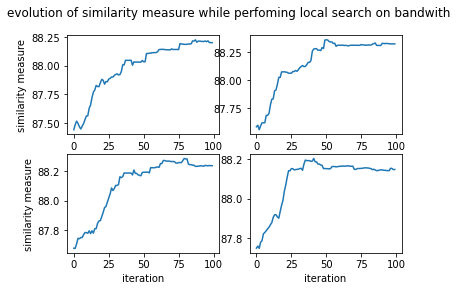

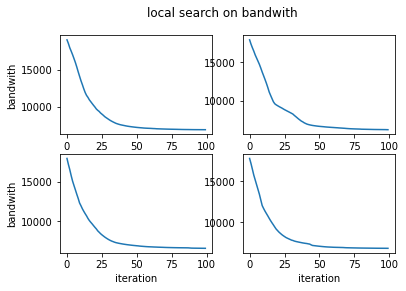

In [33]:
N = 90
nb_tests = 4
fig, axs = plt.subplots(nb_tests//2, nb_tests//2)
fig1, axs1 = plt.subplots(nb_tests//2, nb_tests//2)
for i in range(nb_tests):
    graph_sbm = create_sbm_graph(N)
    weights = get_adjacency_matrix(graph_sbm)
    spectrogram = spectrogram_with_several_repartitions(graph_sbm, nb_repartitions=1)
    initial_solution = np.random.permutation(N)
    best_sol, best_val, similarities, bandwiths = local_search(initial_solution, graph_sbm, spectrogram, nb_max_iter=100)
    axs[i//2, i%2].plot(similarities)
    axs1[i//2, i%2].plot(bandwiths)
    axs[i//2, i%2].set(xlabel='iteration', ylabel='similarity measure' if i%2 == 0 else '')
    axs1[i//2, i%2].set(xlabel='iteration', ylabel='bandwith' if i%2 == 0 else '')
    
fig1.suptitle('local search on bandwith')
fig.suptitle('evolution of similarity measure while perfoming local search on bandwith')